In [1]:
!nvidia-smi

Fri Aug  7 08:09:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import pandas as pd
import random
import os
import glob
import copy
import cv2
from tqdm import tqdm as tqdm
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from PIL import Image

# for creating validation set
from sklearn.model_selection import train_test_split

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)


best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Copied files from drive to local, for faster training/processing

!cp -R /content/drive/"My Drive"/APTOS/Dataset/train_images ./


In [5]:
!cp -R /content/drive/"My Drive"/APTOS/Dataset/train.csv ./

In [6]:
!ls -lrt

total 200
drwxr-xr-x 1 root root   4096 Jul 30 16:30 sample_data
drwx------ 4 root root   4096 Aug  7 08:10 drive
drwx------ 2 root root 135168 Aug  7 08:29 train_images
-rw------- 1 root root  54948 Aug  7 08:29 train.csv


In [7]:
# Train samples from Non DP data
print('All Samples in Train Data')
!ls -l train_images | wc -l

All Samples in Train Data
3663


In [8]:
# Create APTOS Dataset class

class APTOSData(Dataset):
    def __init__(self, data_dir, df_data, transform = None):
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path) 
        if self.transform is not None:
            image = self.transform(image)     
        return image, label

In [9]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                          
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                         
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])



In [10]:
df = pd.read_csv('train.csv')

print("Number of Labels :{}".format(len(np.unique(df['diagnosis']))))

Number of Labels :5


In [11]:
train_dataset = APTOSData('train_images', df , transform=train_transforms)

In [12]:
train_idx, valid_idx= train_test_split(
    np.arange(len(train_dataset)), test_size=0.21, random_state=42, shuffle=True, stratify=df['diagnosis'])

In [13]:
print(len(valid_idx))
print(len(train_idx))

770
2892


In [14]:
# Create Samplers
# Pass train_sampler to train_data , this gives non images for training
# Pass valid_sampler to train_dataset, this gives non dp images for validation
# We are not using DP images here
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler = train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler = valid_sampler)

### Original Images

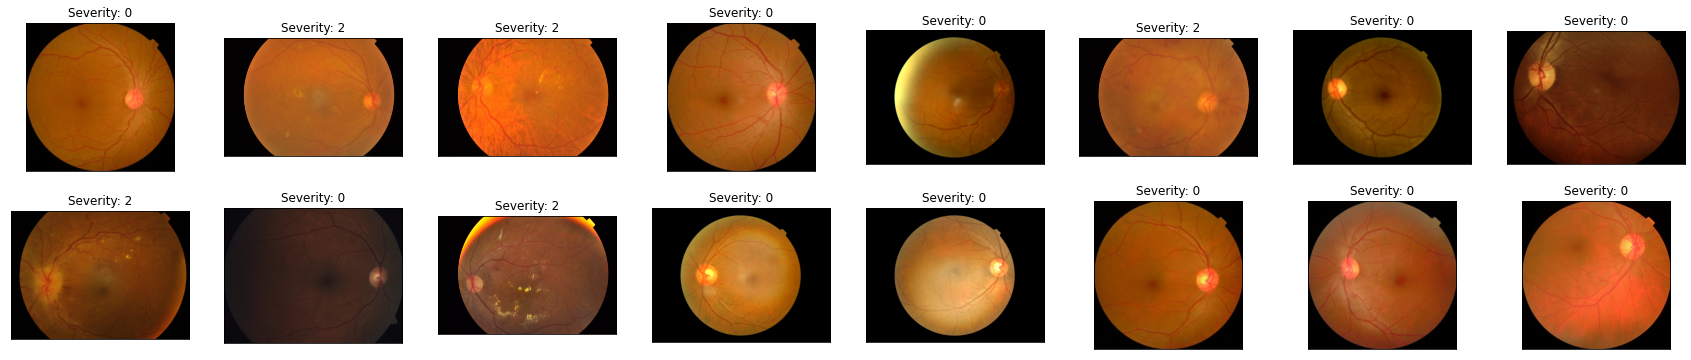

In [15]:
fig = plt.figure(figsize=(30, 6))
#base_dir = '/content/drive/My Drive/APTOS/Dataset'
base_dir = './'
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = df.loc[df['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=5)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
for name, param in model.named_parameters():
  print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [19]:
h = [name for name, param in model.named_parameters() if 'fc' not in name]

In [20]:
print(h)

['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 'layer3.1.

In [21]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [22]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [23]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 2
    S = 0.3
    z = 26.1 # DP-SGD with sampling rate = 4.37% and noise_multiplier = 26.1 iterated over 1145 steps satisfies differential privacy with eps = 0.25 and delta = 0.0001.
            # The optimal RDP order is 63.0
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        ##print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [24]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            ##print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [25]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, {'params': model.fc.parameters(), 'lr': 1e-3}], lr=5e-4, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [26]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    #test_loss, test_acc, true_labels, pred_labels = run_epoch(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    #print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        #best_test_loss = test_loss
        #best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0


23it [05:05, 13.28s/it]



Train loss: 1.6575250159139219, Train accuracy: 0.10235131531953812
Val loss: 1.6722254071916853, Val accuracy: 0.10259740054607391



0it [00:00, ?it/s]

=============== Epoch: 1


23it [04:55, 12.86s/it]



Train loss: 1.5684898780739827, Train accuracy: 0.3105117678642273
Val loss: 1.483621426991054, Val accuracy: 0.4701298475265503



0it [00:00, ?it/s]

=============== Epoch: 2


23it [04:48, 12.53s/it]
0it [00:00, ?it/s]


Train loss: 1.5358361368593962, Train accuracy: 0.3976486921310425
Val loss: 1.5684256894247872, Val accuracy: 0.492207795381546

=============== Epoch: 3


23it [04:49, 12.59s/it]
0it [00:00, ?it/s]


Train loss: 1.5581113151882007, Train accuracy: 0.48962655663490295
Val loss: 1.5971113273075648, Val accuracy: 0.4337662160396576

=============== Epoch: 4


23it [04:49, 12.58s/it]
0it [00:00, ?it/s]


Train loss: 1.6280109571373982, Train accuracy: 0.21887966990470886
Val loss: 1.7187705891472953, Val accuracy: 0.08441558480262756

=============== Epoch: 5


23it [04:49, 12.60s/it]
0it [00:00, ?it/s]


Train loss: 1.6868909027265466, Train accuracy: 0.15733057260513306
Val loss: 1.4841538667678833, Val accuracy: 0.48831167817115784

=============== Epoch: 6


23it [04:53, 12.75s/it]
0it [00:00, ?it/s]


Train loss: 1.501944484918014, Train accuracy: 0.4363762140274048
Val loss: 1.5058166299547469, Val accuracy: 0.34155842661857605

=============== Epoch: 7


23it [04:47, 12.52s/it]
0it [00:00, ?it/s]


Train loss: 1.5973435588504956, Train accuracy: 0.24757952988147736
Val loss: 1.976897086415972, Val accuracy: 0.11818181723356247

=============== Epoch: 8


23it [04:55, 12.86s/it]
0it [00:00, ?it/s]


Train loss: 2.1939217318659243, Train accuracy: 0.10338865965604782
Val loss: 2.911870683942522, Val accuracy: 0.09090908616781235

=============== Epoch: 9


23it [04:49, 12.57s/it]
0it [00:00, ?it/s]


Train loss: 2.086884400118952, Train accuracy: 0.22060857713222504
Val loss: 1.926377262387957, Val accuracy: 0.05454545468091965

=============== Epoch: 10


23it [04:45, 12.42s/it]
0it [00:00, ?it/s]


Train loss: 3.0336092710494995, Train accuracy: 0.08506224304437637
Val loss: 3.3205108983176097, Val accuracy: 0.05324675142765045

=============== Epoch: 11


23it [04:44, 12.35s/it]
0it [00:00, ?it/s]


Train loss: 4.552550657935765, Train accuracy: 0.052558783441782
Val loss: 6.375448840005057, Val accuracy: 0.05324675142765045

=============== Epoch: 12


23it [04:43, 12.31s/it]
0it [00:00, ?it/s]


Train loss: 5.648154155067775, Train accuracy: 0.052558783441782
Val loss: 4.860046931675503, Val accuracy: 0.05324675142765045

=============== Epoch: 13


23it [04:42, 12.27s/it]
0it [00:00, ?it/s]


Train loss: 8.08983788282975, Train accuracy: 0.052558783441782
Val loss: 10.543922015598842, Val accuracy: 0.05324675142765045

=============== Epoch: 14


23it [04:41, 12.24s/it]
0it [00:00, ?it/s]


Train loss: 10.145137683204982, Train accuracy: 0.05221300199627876
Val loss: 15.487903050013951, Val accuracy: 0.05324675142765045

=============== Epoch: 15


23it [04:39, 12.15s/it]
0it [00:00, ?it/s]


Train loss: 14.233997510827106, Train accuracy: 0.056708160787820816
Val loss: 13.525172506059919, Val accuracy: 0.05324675142765045

=============== Epoch: 16


23it [04:38, 12.09s/it]
0it [00:00, ?it/s]


Train loss: 20.98180621603261, Train accuracy: 0.052558783441782
Val loss: 24.115339824131556, Val accuracy: 0.05324675142765045

=============== Epoch: 17


23it [04:36, 12.02s/it]
0it [00:00, ?it/s]


Train loss: 19.286990373030953, Train accuracy: 0.05325034633278847
Val loss: 22.8285334450858, Val accuracy: 0.05324675142765045

=============== Epoch: 18


23it [04:36, 12.04s/it]
0it [00:00, ?it/s]


Train loss: 17.065127289813496, Train accuracy: 0.12033195048570633
Val loss: 11.81423991067069, Val accuracy: 0.27532467246055603

=============== Epoch: 19


23it [04:36, 12.02s/it]
0it [00:00, ?it/s]


Train loss: 15.569346552309783, Train accuracy: 0.44294607639312744
Val loss: 17.79317855834961, Val accuracy: 0.4740259647369385

=============== Epoch: 20


23it [04:33, 11.89s/it]
0it [00:00, ?it/s]


Train loss: 29.242742870164953, Train accuracy: 0.17496542632579803
Val loss: 44.77139500209263, Val accuracy: 0.05324675142765045

=============== Epoch: 21


23it [04:28, 11.67s/it]
0it [00:00, ?it/s]


Train loss: 49.06822693866232, Train accuracy: 0.052558783441782
Val loss: 88.55078233991351, Val accuracy: 0.05324675142765045

=============== Epoch: 22


23it [04:28, 11.68s/it]
0it [00:00, ?it/s]


Train loss: 94.82513991646145, Train accuracy: 0.05152143910527229
Val loss: 108.45526559012276, Val accuracy: 0.05324675142765045

=============== Epoch: 23


23it [04:27, 11.65s/it]
0it [00:00, ?it/s]


Train loss: 104.84992118503736, Train accuracy: 0.052558783441782
Val loss: 99.31037902832031, Val accuracy: 0.05324675142765045

=============== Epoch: 24


23it [04:28, 11.67s/it]
0it [00:00, ?it/s]


Train loss: 64.7408908346425, Train accuracy: 0.0535961277782917
Val loss: 72.51179613385882, Val accuracy: 0.05324675142765045

=============== Epoch: 25


23it [04:28, 11.69s/it]
0it [00:00, ?it/s]


Train loss: 93.1263722958772, Train accuracy: 0.09681881219148636
Val loss: 75.14127295357841, Val accuracy: 0.357142835855484

=============== Epoch: 26


23it [04:31, 11.82s/it]
0it [00:00, ?it/s]


Train loss: 122.77060168722402, Train accuracy: 0.10165975242853165
Val loss: 213.20890372140067, Val accuracy: 0.055844154208898544

=============== Epoch: 27


23it [04:36, 12.01s/it]
0it [00:00, ?it/s]


Train loss: 234.9020113737687, Train accuracy: 0.05394190922379494
Val loss: 245.52562386648995, Val accuracy: 0.051948051899671555

=============== Epoch: 28


23it [04:40, 12.18s/it]
0it [00:00, ?it/s]


Train loss: 312.91485595703125, Train accuracy: 0.052558783441782
Val loss: 292.34153965541293, Val accuracy: 0.05324675142765045

=============== Epoch: 29


23it [04:45, 12.43s/it]
0it [00:00, ?it/s]


Train loss: 180.68541551672894, Train accuracy: 0.10027662664651871
Val loss: 88.26284463065011, Val accuracy: 0.2870129942893982

=============== Epoch: 30


23it [04:42, 12.26s/it]
0it [00:00, ?it/s]


Train loss: 136.3809764696204, Train accuracy: 0.14107884466648102
Val loss: 185.4275381905692, Val accuracy: 0.05324675142765045

=============== Epoch: 31


23it [04:49, 12.61s/it]
0it [00:00, ?it/s]


Train loss: 241.51963408096978, Train accuracy: 0.06396957486867905
Val loss: 271.8810119628906, Val accuracy: 0.048051945865154266

=============== Epoch: 32


23it [04:51, 12.65s/it]
0it [00:00, ?it/s]


Train loss: 323.2126000445822, Train accuracy: 0.05186722055077553
Val loss: 367.13262939453125, Val accuracy: 0.05454545468091965

=============== Epoch: 33


23it [04:50, 12.63s/it]
0it [00:00, ?it/s]


Train loss: 287.0548327902089, Train accuracy: 0.06673582643270493
Val loss: 411.97157069614957, Val accuracy: 0.05324675142765045

=============== Epoch: 34


23it [04:47, 12.52s/it]
0it [00:00, ?it/s]


Train loss: 467.3691950259001, Train accuracy: 0.057399723678827286
Val loss: 548.73046875, Val accuracy: 0.051948051899671555

=============== Epoch: 35


23it [04:40, 12.18s/it]
0it [00:00, ?it/s]


Train loss: 568.9096281632134, Train accuracy: 0.05705394223332405
Val loss: 633.3552507672991, Val accuracy: 0.055844154208898544

=============== Epoch: 36


23it [04:37, 12.06s/it]
0it [00:00, ?it/s]


Train loss: 666.3177357549253, Train accuracy: 0.06915629655122757
Val loss: 630.0609719412668, Val accuracy: 0.072727270424366

=============== Epoch: 37


23it [04:38, 12.09s/it]
0it [00:00, ?it/s]


Train loss: 618.3874007515285, Train accuracy: 0.07607192546129227
Val loss: 445.78271484375, Val accuracy: 0.1090909093618393

=============== Epoch: 38


23it [04:47, 12.49s/it]
0it [00:00, ?it/s]


Train loss: 435.0263207477072, Train accuracy: 0.10304287821054459
Val loss: 640.3883318219866, Val accuracy: 0.05974026024341583

=============== Epoch: 39


23it [04:47, 12.50s/it]
0it [00:00, ?it/s]


Train loss: 565.4588397482167, Train accuracy: 0.07814661413431168
Val loss: 490.01121303013394, Val accuracy: 0.13506492972373962

=============== Epoch: 40


23it [04:51, 12.69s/it]
0it [00:00, ?it/s]


Train loss: 435.0162048339844, Train accuracy: 0.2997925281524658
Val loss: 679.7046595982143, Val accuracy: 0.1766233742237091

=============== Epoch: 41


23it [04:48, 12.56s/it]
0it [00:00, ?it/s]


Train loss: 560.0167249596637, Train accuracy: 0.353042870759964
Val loss: 403.9293125697545, Val accuracy: 0.4233766198158264

=============== Epoch: 42


23it [04:45, 12.43s/it]
0it [00:00, ?it/s]


Train loss: 707.4116502844769, Train accuracy: 0.23858921229839325
Val loss: 774.862810407366, Val accuracy: 0.16623376309871674

=============== Epoch: 43


23it [04:48, 12.53s/it]
0it [00:00, ?it/s]


Train loss: 837.6150512695312, Train accuracy: 0.1874135583639145
Val loss: 638.4961395263672, Val accuracy: 0.37532466650009155

=============== Epoch: 44


23it [04:49, 12.60s/it]
0it [00:00, ?it/s]


Train loss: 813.7852623980979, Train accuracy: 0.22579529881477356
Val loss: 1030.1827566964287, Val accuracy: 0.18571428954601288

=============== Epoch: 45


23it [04:45, 12.41s/it]
0it [00:00, ?it/s]


Train loss: 1274.8574537194293, Train accuracy: 0.13416321575641632
Val loss: 1560.911411830357, Val accuracy: 0.16103896498680115

=============== Epoch: 46


23it [04:44, 12.39s/it]
0it [00:00, ?it/s]


Train loss: 2015.787693189538, Train accuracy: 0.11791148036718369
Val loss: 1437.717782156808, Val accuracy: 0.09350649267435074

=============== Epoch: 47


23it [04:44, 12.35s/it]
0it [00:00, ?it/s]


Train loss: 1925.8442807404892, Train accuracy: 0.1061549112200737
Val loss: 2354.469796316964, Val accuracy: 0.1389610320329666

=============== Epoch: 48


23it [04:40, 12.19s/it]
0it [00:00, ?it/s]


Train loss: 2907.396786897079, Train accuracy: 0.13243430852890015
Val loss: 3722.295724051339, Val accuracy: 0.12727272510528564

=============== Epoch: 49


23it [04:42, 12.29s/it]



Train loss: 3002.573486328125, Train accuracy: 0.14142462611198425
Val loss: 4652.27654157366, Val accuracy: 0.11948052048683167

